In [1]:
from braindecode.datasets import BaseConcatDataset, BaseDataset
import os

import numpy as np
import pandas as pd
import mne
from mne.datasets.sleep_physionet.age import fetch_data


from braindecode.datautil.preprocess import preprocess, Preprocessor
from braindecode.datautil.windowers import create_windows_from_events
from braindecode.datautil.preprocess import zscore

import numpy as np
import copy
from tqdm import tqdm
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from scipy.interpolate import interp1d
from sklearn.metrics import (
    cohen_kappa_score,
    accuracy_score,
    f1_score,
    confusion_matrix,
)
from sklearn.linear_model import LogisticRegression as LR


In [2]:
class SleepPhysionet(BaseConcatDataset):
    def __init__(
        self,
        subject_ids=None,
        recording_ids=None,
        preload=False,
        load_eeg_only=True,
        crop_wake_mins=30,
        crop=None,
    ):
        if subject_ids is None:
            subject_ids = range(83)
        if recording_ids is None:
            recording_ids = [1, 2]

        paths = fetch_data(
            subject_ids,
            recording=recording_ids,
            on_missing="warn",
            path=r"C:\users\likit\mne_data",
        )

        all_base_ds = list()
        for p in paths:
            raw, desc = self._load_raw(
                p[0],
                p[1],
                preload=preload,
                load_eeg_only=load_eeg_only,
                crop_wake_mins=crop_wake_mins,
                crop=crop,
            )
            base_ds = BaseDataset(raw, desc)
            all_base_ds.append(base_ds)
        super().__init__(all_base_ds)

    @staticmethod
    def _load_raw(
        raw_fname,
        ann_fname,
        preload,
        load_eeg_only=True,
        crop_wake_mins=False,
        crop=None,
    ):
        ch_mapping = {
            "EOG horizontal": "eog",
            "Resp oro-nasal": "misc",
            "EMG submental": "misc",
            "Temp rectal": "misc",
            "Event marker": "misc",
        }
        exclude = list(ch_mapping.keys()) if load_eeg_only else ()

        raw = mne.io.read_raw_edf(raw_fname, preload=preload, exclude=exclude)
        annots = mne.read_annotations(ann_fname)
        raw.set_annotations(annots, emit_warning=False)

        if crop_wake_mins > 0:
            # Find first and last sleep stages
            mask = [x[-1] in ["1", "2", "3", "4", "R"] for x in annots.description]
            sleep_event_inds = np.where(mask)[0]

            # Crop raw
            tmin = annots[int(sleep_event_inds[0])]["onset"] - crop_wake_mins * 60
            tmax = annots[int(sleep_event_inds[-1])]["onset"] + crop_wake_mins * 60
            raw.crop(tmin=max(tmin, raw.times[0]), tmax=min(tmax, raw.times[-1]))

        # Rename EEG channels
        ch_names = {i: i.replace("EEG ", "") for i in raw.ch_names if "EEG" in i}
        raw.rename_channels(ch_names)

        if not load_eeg_only:
            raw.set_channel_types(ch_mapping)

        if crop is not None:
            raw.crop(*crop)

        basename = os.path.basename(raw_fname)
        subj_nb = int(basename[3:5])
        sess_nb = int(basename[5])
        desc = pd.Series({"subject": subj_nb, "recording": sess_nb}, name="")
       

        return raw, desc


random_state = 1234
n_jobs = -1
sfreq = 100
high_cut_hz = 30

EPOCH_LEN = 15

SUBJECTS = np.arange(3)
RECORDINGS = [1, 2]

dataset = SleepPhysionet(
    subject_ids=SUBJECTS, recording_ids=RECORDINGS, crop_wake_mins=30
)



Extracting EDF parameters from C:\users\likit\mne_data\physionet-sleep-data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\users\likit\mne_data\physionet-sleep-data\SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\users\likit\mne_data\physionet-sleep-data\SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\users\likit\mne_data\physionet-sleep-data\SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\users\likit\mne_data\physionet-sleep-data\SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\users\likit\mne_data\physionet-sleep-data\SC4022E0-PSG.edf...
EDF file 

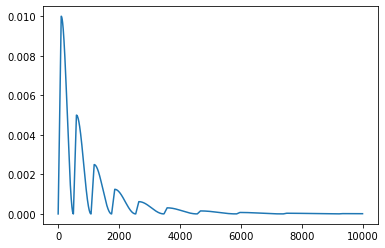

In [32]:
%matplotlib inline

from multi_epoch.utils import CosineAnnealingWarmupRestarts
import matplotlib.pyplot as plt
import torch
import torchvision.models as models

model = models.resnet18()

a = torch.randn((10, 10), requires_grad=True)
b = torch.randn((10, 10), requires_grad=True)
c = a+b

optimizer = torch.optim.Adam(model.parameters())
scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps = 500, cycle_mult = 1.2, max_lr = 0.01, min_lr = 5e-6, warmup_steps = 100, gamma = 0.5)

step = 0
lrs = []

for i in range(10000):
    step += 1
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    
plt.plot(lrs)


In [ ]:
e-5